# Day 73: ETL Processes and Data Pipelines in Machine Learning

## Introduction to ETL in Machine Learning

In this lesson, we explore **ETL (Extract, Transform, Load)** processes and how they form the backbone of modern machine learning pipelines. ETL is crucial for:
- Collecting data from multiple sources
- Transforming raw data into features
- Loading processed data for model training

### What is ETL?

**ETL** stands for Extract, Transform, and Load:

1. **Extract**: Gathering data from various sources (databases, APIs, files)
2. **Transform**: Cleaning, validating, and engineering features from raw data  
3. **Load**: Storing processed data in a format suitable for ML models

### Why ETL Matters for ML

Good ML models require good data. ETL ensures:
- **Data Quality**: Clean, validated, consistent data
- **Reproducibility**: Same transformations in training and production
- **Scalability**: Efficient processing of large datasets
- **Maintainability**: Modular, versioned data pipelines

### Learning Objectives

By the end of this lesson, you will:
- Understand ETL concepts for machine learning
- Extract data from multiple sources
- Apply data transformations and feature engineering
- Build scikit-learn pipelines
- Monitor data quality
- Create end-to-end ML data pipelines

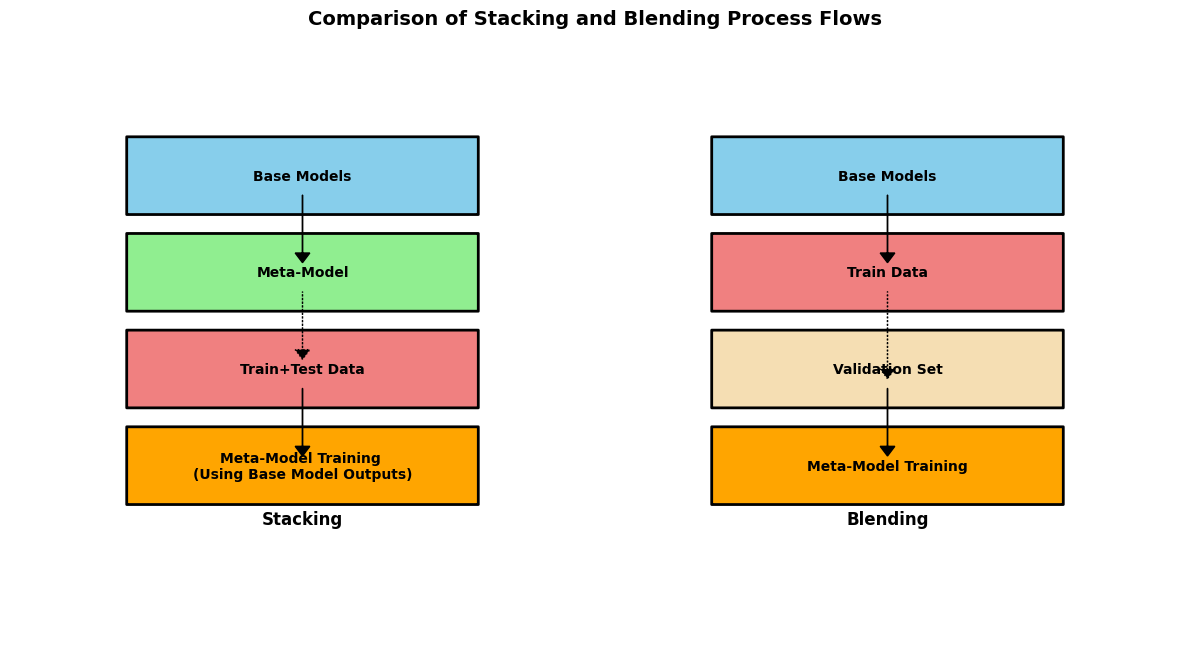

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Helper function for drawing boxes
def draw_box(ax, center, text, color='skyblue'):
    box = FancyBboxPatch((center[0]-60, center[1]-20), 120, 40, boxstyle="round,pad=0.1",
                         ec="black", fc=color, lw=2)
    ax.add_patch(box)
    ax.text(center[0], center[1], text, ha='center', va='center', 
            fontsize=10, weight='bold')

fig, ax = plt.subplots(figsize=(12, 7))

# Set up plotting area
ax.set_xlim(0, 400)
ax.set_ylim(0, 300)
ax.axis('off')

# Stacking flow
draw_box(ax, (100, 250), 'Base Models', 'skyblue')
draw_box(ax, (100, 200), 'Meta-Model', 'lightgreen')
plt.arrow(100, 240, 0, -30, head_width=5, head_length=5, fc='k', ec='k')

draw_box(ax, (100, 150), 'Train+Test Data', 'lightcoral')
draw_box(ax, (100, 100), 'Meta-Model Training \n(Using Base Model Outputs)', 'orange')
plt.arrow(100, 190, 0, -30, head_width=5, head_length=5, fc='k', ec='k', linestyle='dotted')
plt.arrow(100, 140, 0, -30, head_width=5, head_length=5, fc='k', ec='k')
plt.text(100, 70, 'Stacking', fontsize=12, weight='bold', ha='center')

# Blending flow
draw_box(ax, (300, 250), 'Base Models', 'skyblue')
draw_box(ax, (300, 200), 'Train Data', 'lightcoral')
plt.arrow(300, 240, 0, -30, head_width=5, head_length=5, fc='k', ec='k')
draw_box(ax, (300, 150), 'Validation Set', 'wheat')
draw_box(ax, (300, 100), 'Meta-Model Training', 'orange')
plt.arrow(300, 190, 0, -40, head_width=5, head_length=5, fc='k', ec='k', linestyle='dotted')
plt.arrow(300, 140, 0, -30, head_width=5, head_length=5, fc='k', ec='k')
plt.text(300, 70, 'Blending', fontsize=12, weight='bold', ha='center')

plt.suptitle('Comparison of Stacking and Blending Process Flows', fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In the stacking flow, both training and testing data are fed through the base models, and the outputs are then used as inputs to the meta-model, emphasizing the direct flow. Whereas, in blending, a separate validation set is marked for training the meta model, delineating a difference primarily in how the meta-model is trained - showcasing blending's characteristic separation.


# Understanding Stacking

Stacking, or stacked generalization, is a sophisticated ensemble learning technique designed to enhance prediction accuracy by intelligently combining multiple base models. Let's explore the methodology, mathematical underpinnings, and practical considerations involved in stacking.

## Definition

### Stacking

Stacking involves multiple layers of modeling: Firstly, numerous base models are independently trained on the same dataset. Then, a meta-model is trained on the output predictions of these base models. The intuition here is that the meta-model can learn the best way to integrate various base model predictions to minimize overall prediction error. For $n$ base models producing predictions $y_1, y_2, \ldots, y_n$, stacking seeks a meta-model $f$ such that

$$
y_{combined} = f(y_1, y_2, \ldots, y_n)
$$

minimizes the error between $y_{combined}$ and the true values. This framework can advantageously capture the complementary strengths of diverse models.

### Assumptions

For stacking to be effective, a few assumptions should ideally be met:

- **Model Diversity:** The base models should be sufficiently diverse, employing different algorithms or configurations. Similar models might produce correlated errors, reducing the efficacy of stacking.
- **Robust Meta-Model:** The meta-model should be capable of capturing relationships between base model predictions and the target without overfitting. It typically involves regularization or selecting a model with an appropriate complexity.

## Applications

Stacking has wide applications across various machine learning tasks for its ability to harness the collective strengths of multiple models, some of which include:

- **Predictive Analytics:** In domains where precision is paramount, stacking can elevate model performance by optimally combining predictions.
- **Feature Enrichment:** Stacking can also be used as a form of feature transformation, where base model predictions become features for further modeling or analysis.
- **Complex Decision Spaces:** When facing highly non-linear or complex decision spaces, stacking can integrate diverse models' perspective, achieving superior predictive power.

Next, we will implement a simple stacking example using a regression problem. For this, we'll prepare a dataset, choose base learners from different algorithm families (e.g., decision tree, support vector machine), and use a linear regression model as the meta-learner. Understanding how to partition data for training base models and the meta-model is crucial, as is evaluating the stacking model's performance. (This is a good time to use a separate *validation* dataset.)

Note that in practical applications, such as those using `sklearn`, the `StackingRegressor` or `StackingClassifier` provides a streamlined approach to implementing stacking, allowing for easy experimentation with different base and meta-model configurations.


In [19]:
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

# Generate synthetic data
X, y = make_regression(n_samples=200, n_features=10, effective_rank=4, random_state=42)

# List of (name, regressor) tuples for stacking
base_estimators = [
    ('LinearRegression', LinearRegression()),
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42)),
    ('RandomForestRegressor', RandomForestRegressor(random_state=42)),
    ('ExtraTreesRegressor', ExtraTreesRegressor(random_state=42)),
    ('KNeighborsRegressor', KNeighborsRegressor())
]

# Define Stacking Regressor
stacking_reg = StackingRegressor(estimators=base_estimators, final_estimator=Ridge())

# Evaluate individual models and stacking regressor
model_scores = {}
for name, reg in base_estimators + [('StackingRegressor', stacking_reg)]:
    scores = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
    model_scores[name] = scores.mean()

# Convert scores to DataFrame for better visualization
scores_df = pd.DataFrame.from_dict(model_scores, orient='index', columns=['Mean Squared Error'])
scores_df.sort_values(by='Mean Squared Error', ascending=False)

,Mean Squared Error
LinearRegression,-1.303900e-28
StackingRegressor,-2.914391e-06
ExtraTreesRegressor,-1.692866e+01
KNeighborsRegressor,-1.928478e+01
RandomForestRegressor,-2.055500e+01
DecisionTreeRegressor,-4.440315e+01


This table actually shows that Linear regression alone outperforms the stacking regression; however, if that linear regression is actually overfit, then the use of the ensemble should balance that out to some degree.

In the following code example, we will apply multi-level stacking to a regression problem using `sklearn`'s ensemble and model selection modules. We'll briefly review how to use `CrossValPredict` for generating out-of-fold predictions necessary for training our level 1 models.

The key takeaway will be constructing a two-level stacking architecture: initially with diverse base models and subsequently a meta-model that learns from the predictions of the first-level models. The level zero models train on the training data, and the level 1 model(s) train on the level zero predictions.


In [17]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Generate synthetic data
X, y = make_regression(n_samples=200, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define Level 0 models
base_models = [
    ('RandomForestRegressor', RandomForestRegressor(random_state=42)),
    ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=42)),
    ('ExtraTreesRegressor', ExtraTreesRegressor(random_state=42)),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42)),
    ('RandomForestRegressor', RandomForestRegressor(random_state=42)),
]

# Initialize container for the out-of-fold predictions
train_meta = np.zeros((X_train.shape[0], len(base_models)))

# Step 3: Generate out-of-fold predictions for each base model
for i, (name, model) in enumerate(base_models):
    train_meta[:, i] = cross_val_predict(model, X_train, y_train, cv=5, method='predict')

# Step 4: Define the Level 1 model (meta-model)
meta_model = LinearRegression()

# Train the meta-model on the out-of-fold predictions
meta_model.fit(train_meta, y_train)

# Generate meta-features for the test set
test_meta = np.zeros((X_test.shape[0], len(base_models)))
for i, (name, model) in enumerate(base_models):
    model.fit(X_train, y_train)  # Retrain on the full training data
    test_meta[:, i] = model.predict(X_test)

# Predict and evaluate
y_pred = meta_model.predict(test_meta)
mse = mean_squared_error(y_test, y_pred)

model_scores = {}
for name, reg in base_models + [('meta model', meta_model)]:
    scores = cross_val_score(reg, X_test, y_test, cv=10, scoring='neg_mean_squared_error')
    model_scores[name] = scores.mean()

# Convert scores to DataFrame for better visualization
scores_df = pd.DataFrame.from_dict(model_scores, orient='index', columns=['Mean Squared Error'])
scores_df.sort_values(by='Mean Squared Error', ascending=False)

,Mean Squared Error
meta model,-0.013234
ExtraTreesRegressor,-9017.616907
GradientBoostingRegressor,-9578.460404
RandomForestRegressor,-10028.325801
DecisionTreeRegressor,-14171.583767
KNeighborsRegressor,-15257.872850


# Distinguishing Blending from Stacking

When selecting an ensemble technique for a machine learning project, understanding the nuances between blending and stacking is crucial. Both approaches aim at combining different models to enhance overall performance, yet they employ distinct methodologies in utilizing training data, which can significantly impact model outcomes. This section delineates the differences, offering insights for making an informed choice between blending and stacking.

## Key Differences in Approach

- **Training the Meta-learner**: In stacking, the meta-learner is trained on out-of-fold predictions from the base models. This means that each base model is trained on a partition of the training set, and predictions are made on the complementary partition not used for training. These predictions, from each partition, serve as input features for the meta-learner. Conversely, blending bypasses the complexity of out-of-fold predictions by simply splitting the training data into a base training set and a holdout set. The base models are trained on the base training set, and their predictions on the holdout set are used to train the meta-learner.

- **Risk of Information Leakage**: Blending's approach to training the meta-learner is more straightforward and can reduce the risk of information leakage compared to stacking. Since stacking uses out-of-fold predictions based on the training data, there is a higher risk of subtle data leakages if not carefully implemented, especially in complex, multi-level stacking scenarios.

- **Data Utilization and Model Complexity**: Stacking potentially makes better use of the available training data by incorporating out-of-fold predictions, which can lead to a more generalized model. However, it introduces additional complexity and computational overhead. On the other hand, blending, with its more straightforward approach, might not fully leverage the entire dataset but is simpler to implement and could mitigate overfitting due to its clear separation of training data for base learners and the meta-learner.

## Choosing Between Blending and Stacking

The decision to use blending or stacking hinges on several factors, including the specific requirements of the machine learning project, the computational resources available, the degree of acceptable model complexity, and the potential risk of overfitting or information leakage. Blending might be preferred for projects that require a simpler, quicker ensemble method with a lower risk of information leakage. In contrast, stacking is suited for projects where maximizing accuracy is paramount, and the complexity and computational costs are justifiable in light of potential performance gains.

**Applications and Limitations**: Both techniques are widely applicable across a variety of machine learning disciplines – from competitive machine learning contests, where marginal improvements are crucial, to critical business and healthcare applications where predictive accuracy can have significant implications. However, the intelligent application of these methods, mindful of their limitations, is key to fully realizing their benefits without succumbing to their potential pitfalls, such as overfitting in stacking or underutilization of data in blending.

Before diving into the code examples for implementing stacking and blending, we'll introduce the concept of cross-validation and how it plays a critical role in stacking to generate out-of-fold predictions. We'll also touch upon how to split the dataset effectively for blending. The `sklearn` library offers robust tools for cross-validation (`model_selection` module) and ensemble methods, which we will leverage along with `pandas` for data manipulation and `matplotlib` for visualization purposes. In the following code sections, we'll see how these concepts play out in practical scenarios, employing common machine learning algorithms as base and meta-learners.


In [20]:
# Split the data into base training, holdout, and test sets
X_base_train, X_temp, y_base_train, y_temp = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
X_holdout, X_test, y_holdout, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)  # 0.4 of 0.5 = 0.2 of the original

# Define Level 0 models
base_models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor', RandomForestRegressor(random_state=42)),
    ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=42))
]

# Train Level 0 models on the base training set and predict on the holdout set
holdout_predictions = np.zeros((X_holdout.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    model.fit(X_base_train, y_base_train)
    holdout_predictions[:, i] = model.predict(X_holdout)

# Train the Level 1 meta-model on the holdout predictions
meta_model = LinearRegression()
meta_model.fit(holdout_predictions, y_holdout)

# Prepare test features for the meta-model
test_predictions = np.zeros((X_test.shape[0], len(base_models)))
for i, (name, model) in enumerate(base_models):
    test_predictions[:, i] = model.predict(X_test)

# Predict and evaluate on the test set
y_pred_blend = meta_model.predict(test_predictions)
mse_blend = mean_squared_error(y_test, y_pred_blend)

mse_blend


0.01465719578968053

## Exercise For The Reader

In this exercise, you will put into practice the stacking ensemble technique discussed in the lesson. You will work with a dataset of your choice; this could be a publicly available dataset suited to regression or classification tasks, such as the Boston Housing dataset for regression or the Iris dataset for classification.

### Dataset Introduction
- **Dataset Selection:** Choose a dataset that you are familiar with, or explore new datasets that interest you. Make sure the dataset is suited for either a regression or classification problem.
- **Preprocessing:** Conduct necessary preprocessing steps such as handling missing values, encoding categorical variables, and normalizing or standardizing the features.

### Base Model Training
- **Model Selection:** Select three distinct machine learning algorithms to serve as your base models. These could include, but are not limited to, decision trees, support vector machines, and neural networks. The choice of models should reflect a diversity of machine learning approaches.
- **Validation Strategy:** Split your dataset into training and validation sets. Alternatively, you can use cross-validation to generate out-of-fold predictions for the entire dataset, which will then be used as features for your meta-model.

### Stacking Implementation
- **Definition:** Recall that stacking involves training a meta-model to optimally combine the predictions of several base models. The goal is to leverage the diverse strengths of each base model to achieve superior prediction accuracy.

- **Meta-Model Training:** Use the predictions from your base models on the validation set (or out-of-fold predictions) as features to train a meta-model. Depending on the nature of your task (regression or classification), suggestions for a meta-model include linear regression or logistic regression, respectively.

- **Evaluation:** Compare the performance of your stacked model to each individual base model and a conventional ensemble method like Random Forest. Evaluate using appropriate metrics like RMSE for regression tasks or accuracy for classification tasks.

$$\text{Performance Metric} = 
\begin{cases} 
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} & \text{for regression}\\
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} & \text{for classification}
\end{cases}$$

- **Reflection:** Reflect on the performance of the stacked model compared to the base models and the standard ensemble method. Consider the following:
  - Did the stacking model outperform the base models and the conventional ensemble method? Why or why not?
  - What insights can be drawn about the use of stacking in improving model performance?
  - How could the model be improved further? Consider experimenting with different sets of base models, or adding another layer of meta-models for multi-level stacking.

This exercise serves as an application of the stacking ensemble technique, reinforcing the concepts discussed in the lesson and offering hands-on experience. By completing it, you'll gain insights into the effectiveness of ensemble methods in predictive modeling and develop skills that are directly applicable to real-world machine learning projects.


### Stacking Model Implementation: A Step-by-Step Guide

#### Step 1: Dataset Preparation



```
1.1. Load your dataset.
1.2. Conduct preprocessing:
    - Handle missing values.
    - Encode categorical variables.
    - Normalize or standardize the features.
1.3. Split the dataset into training and validation sets.
```




#### Step 2: Base Model Selection



```
2.1. Choose three distinct machine learning algorithms as base models.
    Example options: Decision Tree, SVM, Neural Network.
    Note: Ensure diversity in your selection.
```




#### Step 3: Train Base Models



```
3.1. For each base model:
    - Train on the training set.
    - Predict on the validation set.
    - Save the predictions.
```




#### Step 4: Stacking - Preparing Meta Features



```
4.1. Use the predictions from each base model as features for the meta-model.
    - These predictions form a new dataset for training the meta-model.
```




#### Step 5: Meta-Model Selection



```
5.1. Choose a meta-model algorithm appropriate for your task.
    - For regression tasks: Consider Linear Regression.
    - For classification tasks: Consider Logistic Regression.
```




#### Step 6: Train Meta-Model



```
6.1. Train the selected meta-model on the new dataset created in Step 4.

```



#### Step 7: Evaluation and Comparison



```
7.1. Use the meta-model to make final predictions on a separate test set or use cross-validation.
7.2. Evaluate the performance using suitable metrics:
    - RMSE for regression.
    - Accuracy for classification.
7.3. Compare the performance:
    - Between individual base models and the stacked model.
    - Between a conventional ensemble method (e.g., Random Forest) and the stacked model.
```




#### Step 8: Reflection



```
8.1. Reflect on the performance of the stacking model:
    - Did it outperform the base models and the conventional ensemble?
    - Why did the stacking model perform as it did?
    - How can the performance be improved further?
     Example considerations for improvement:
        - Experimenting with different base models.
        - Adding another layer of meta-models (multi-level stacking).
```




#### Visualization Note (Optional):



```
- Alongside the numerical evaluation, visualize the performance comparisons.
- Use bar charts or line graphs to display performance metrics across different models.
```


Have fun!